In [1]:
!pip install gensim spacy

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk
import spacy

In [3]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 262.6 kB/s eta 0:00:49
     --------------------------------------- 0.1/12.8 MB 409.6 kB/s eta 0:00:32
     - -------------------------------------- 0.3/12.8 MB 1.8 MB/s eta 0:00:07
     - -------------------------------------- 0.6/12.8 MB 2.4 MB/s eta 0:00:06
     --- ------------------------------------ 1.0/12.8 MB 3.9 MB/s eta 0:00:04
     ---- ----------------------------------- 1.4/12.8 MB 4.4 MB/s eta 0:00:03
     ----- ---------------------------------- 1.8/12.8 MB 5.0 MB/s eta 0:00:03
     ------- -------------------------------- 2.3/12.8 MB 5.4 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 6.0 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 MB 6.2 MB/s eta 

In [4]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel

nlp = spacy.load("en_core_web_sm")

# Download stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Prath\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
df = pd.read_csv("Top_Artists.csv")  # or "Top_Artists.csv"
df = df.dropna(subset=['Lyrics'])
df.head()


,SongName,AlbumName,AlbumLink,Year,PlayCount,Lyrics,SongLink,Duration,artist
0,BIRDS OF A FEATHER,HIT ME HARD AND SOFT,https://open.spotify.com/album/7aJuG4TFXa2hmE4...,2024,3218891371,('Til I'm in the grave)\r\nI want you to stay\...,https://open.spotify.com/track/6dOtVTDdiauQNBQ...,210,Billie_Ilish
1,you should see me in a crown,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",https://open.spotify.com/album/0S0KGZnfBGSIssf...,2019,1000101010,"Bite my tongue, bide my time\r\nWearing a warn...",https://open.spotify.com/track/3XF5xLJHOQQRbWy...,180,Billie_Ilish
2,GOLDWING,Happier Than Ever,https://open.spotify.com/album/0JGOiO34nwfUdDr...,2021,162632187,He hath come to the bosom of his beloved\r\nSm...,https://open.spotify.com/track/0FfqyjhB6Kspvit...,151,Billie_Ilish
3,Getting Older,Happier Than Ever,https://open.spotify.com/album/0JGOiO34nwfUdDr...,2021,334347982,"I'm getting older, I think I'm aging well\r\nI...",https://open.spotify.com/track/4HOryCnbme0zBnF...,244,Billie_Ilish
4,Your Power,Happier Than Ever,https://open.spotify.com/album/0JGOiO34nwfUdDr...,2021,526977340,Try not to abuse your power\r\nI know we didn'...,https://open.spotify.com/track/042Sl6Mn83JHyLE...,245,Billie_Ilish


In [6]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', ' ', text)

    doc = nlp(text)
    tokens = []

    for token in doc:
        if token.is_stop:
            continue
        if token.lemma_ == "-PRON-":
            continue
        if len(token.lemma_) < 3:
            continue
        tokens.append(token.lemma_)
    
    return tokens


In [7]:
texts = df['Lyrics'].astype(str).apply(preprocess).tolist()
texts[:2]


[['til',
  'grave',
  'want',
  'stay',
  '\r\n ',
  'til',
  'grave',
  '\r\n ',
  'til',
  'rot',
  'away',
  'dead',
  'bury',
  '\r\n ',
  'til',
  'casket',
  'carry',
  '\r\n ',
  'cause',
  'alright',
  'turnin',
  'blue',
  'don',
  'save',
  'leave',
  'lose',
  'baby',
  'bird',
  'feather',
  'stick',
  'know',
  'say',
  'think',
  'wasn',
  'well',
  'change',
  'weather',
  'forever',
  'forever',
  'well',
  'don',
  'know',
  'cryin',
  'don',
  'think',
  'love',
  'long',
  'baby',
  'love',
  'til',
  'day',
  'die',
  '\r\n ',
  'til',
  'day',
  'die',
  '\r\n ',
  'til',
  'light',
  'leave',
  'eye',
  '\r\n ',
  'til',
  'day',
  'die',
  'want',
  'look',
  'wouldn',
  'believe',
  'tell',
  'compliment',
  'throw',
  'shit',
  'tell',
  'bit',
  'don',
  'mind',
  'polluted',
  'wanna',
  'quit',
  'don',
  'stupid',
  'don',
  'know',
  'cryin',
  'don',
  'think',
  'love',
  'long',
  'baby',
  'don',
  'wanna',
  'goodbye',
  'bird',
  'feather',
  'stick'

In [8]:
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


In [9]:
def train_gensim_lda(k):
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=k,
        passes=10,
        random_state=42
    )
    return lda_model


In [10]:
def compute_coherence(model):
    coherence_model = CoherenceModel(
        model=model,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    return coherence_model.get_coherence()


In [11]:
topic_nums = [2, 4, 5, 7, 10, 12, 15]
coherence_scores = []

for k in topic_nums:
    lda_k = train_gensim_lda(k)
    coh = compute_coherence(lda_k)
    coherence_scores.append((k, coh))
    print(f"K={k}, Coherence={coh}")


K=2, Coherence=0.3169809993397535
K=4, Coherence=0.31223590641925525
K=5, Coherence=0.3227583848145465
K=7, Coherence=0.33450688340079676
K=10, Coherence=0.32193583772244466
K=12, Coherence=0.3205781914913652
K=15, Coherence=0.3005967944315018


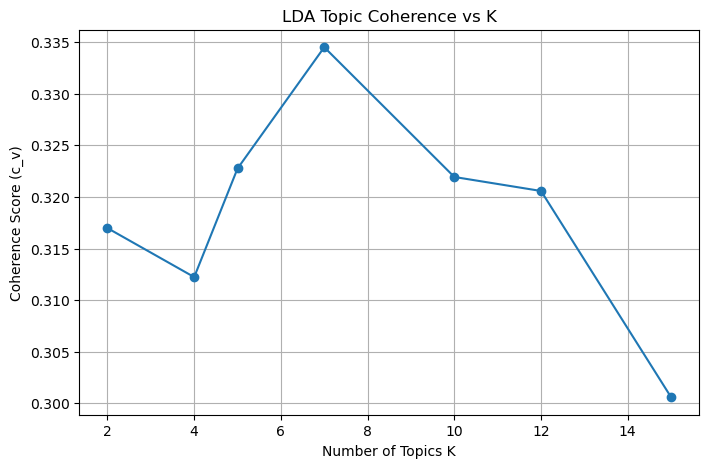

In [12]:
ks = [x[0] for x in coherence_scores]
scores = [x[1] for x in coherence_scores]

plt.figure(figsize=(8,5))
plt.plot(ks, scores, marker='o')
plt.xlabel("Number of Topics K")
plt.ylabel("Coherence Score (c_v)")
plt.title("LDA Topic Coherence vs K")
plt.grid(True)
plt.show()


In [13]:
best_k = max(coherence_scores, key=lambda x: x[1])
print("Best number of topics (K):", best_k[0], "with coherence:", best_k[1])


Best number of topics (K): 7 with coherence: 0.33450688340079676
